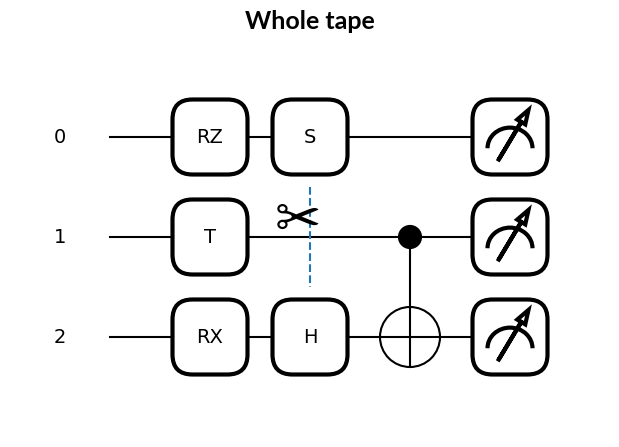

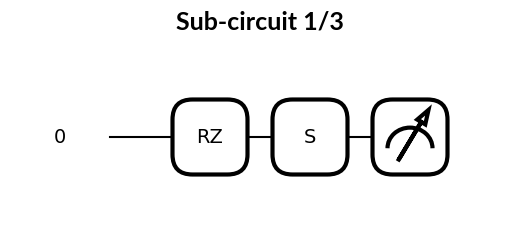

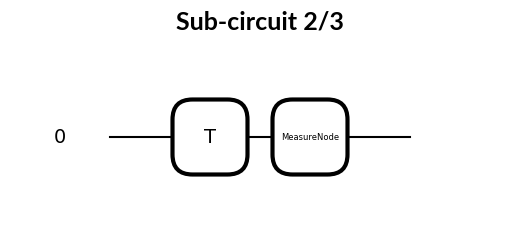

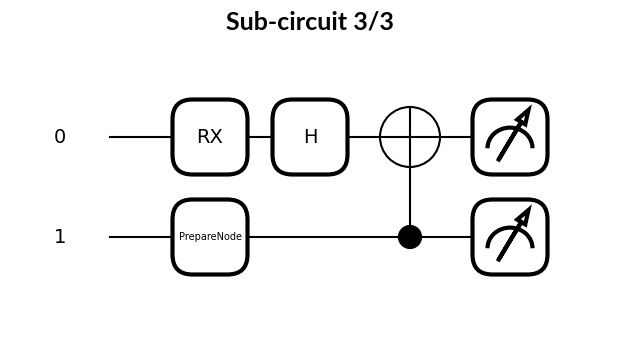

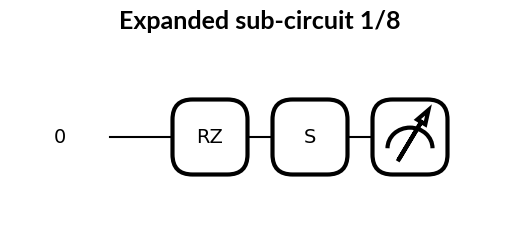

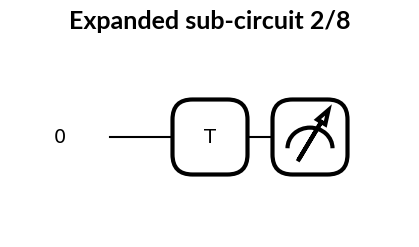

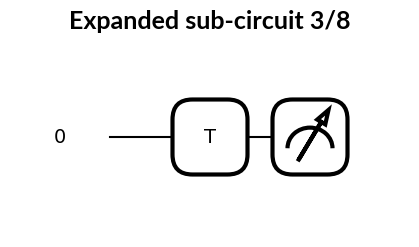

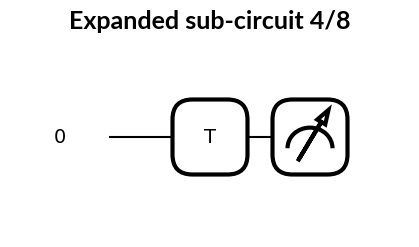

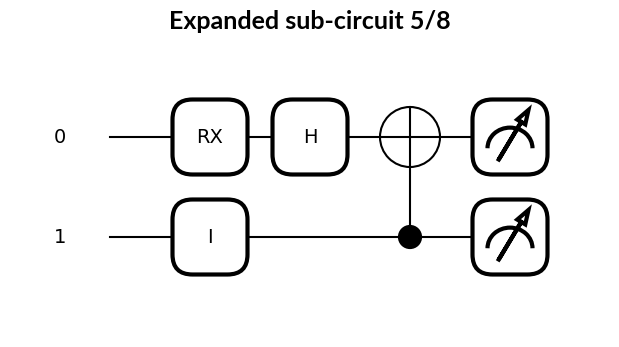

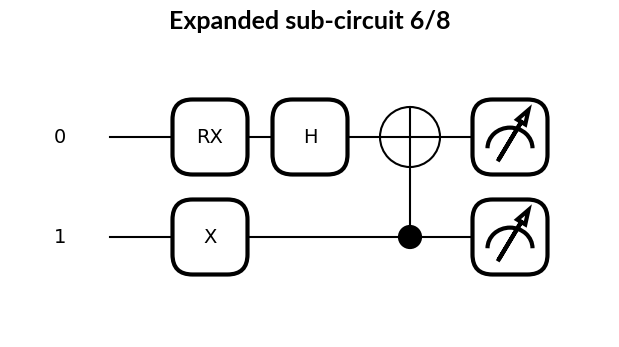

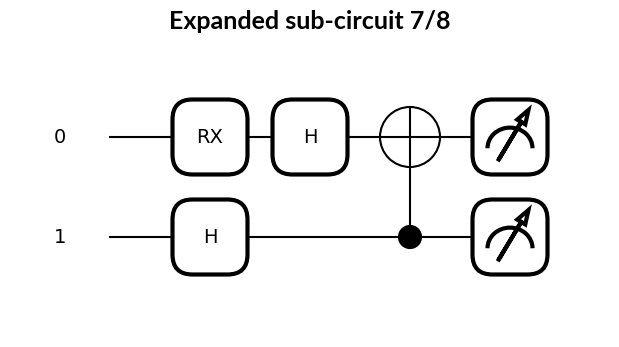

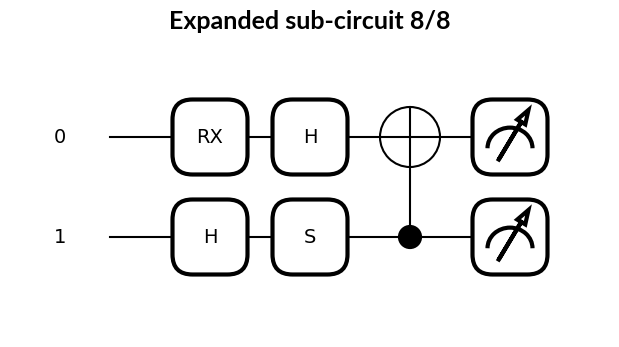

In [6]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

def draw_tape(tape, title, filename):
    title_font = {
        'fontsize': 18, 
        'fontweight': 'bold', 
        'fontname': 'Lato',
    }
    fig, ax = qml.drawer.tape_mpl(tape)
    ax.set_title(title, fontdict=title_font)
    plt.savefig(filename, format="pdf", bbox_inches="tight")
    return fig

dev = qml.device("default.qubit", wires=3)

ops = [
    qml.RZ(np.pi / 4, wires=0),
    qml.T(wires=1),
    qml.RX(-0.5, wires=2),
    qml.H(wires=2),
    qml.S(wires=0),
    qml.WireCut(wires=1),
    qml.CNOT(wires=[1, 2]),
]

measurements = [qml.expval(qml.pauli.string_to_pauli_word("ZZZ"))]
original_tape = qml.tape.QuantumTape(ops, measurements)
draw_tape(original_tape, "Whole tape", "pennylane-cutting.pdf")

#cut_graph = qml.qcut.find_and_place_cuts(
#    graph = qml.qcut.tape_to_graph(original_tape),
#    cut_strategy = qml.qcut.CutStrategy(max_free_wires=2),
#)

graph = qml.qcut.tape_to_graph(original_tape)
qml.qcut.replace_wire_cut_nodes(graph)
fragments, communication_graph = qml.qcut.fragment_graph(graph)
fragment_tapes = [qml.qcut.graph_to_tape(f) for f in fragments]
fragment_tapes = [qml.map_wires(t, dict(zip(t.wires, dev.wires)))[0][0] for t in fragment_tapes]
for i, t in enumerate(fragment_tapes):
    draw_tape(t, f"Sub-circuit {i+1}/{len(fragment_tapes)}", f"pennylane-subcircuit-{i}.pdf")

expanded = [qml.qcut.expand_fragment_tape(t) for t in fragment_tapes]
configurations = []
prepare_nodes = []
measure_nodes = []
for t, p, m in expanded:
    configurations.append(t)
    prepare_nodes.append(p)
    measure_nodes.append(m)
sub_tapes = tuple(tape for c in configurations for tape in c)
for i, t in enumerate(sub_tapes):
    draw_tape(t, f"Expanded sub-circuit {i+1}/{len(sub_tapes)}", f"pennylane-expanded-subcircuit-{i}.pdf")